In [31]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# load data for climate and groundwater level

df_climate_muddy_creek = pd.read_parquet('data/climate/df_climate_muddy_creek.parquet')
df_climate_pueblo = pd.read_parquet('data/climate/df_climate_pueblo.parquet')

df_gwl_muddy_creek = pd.read_parquet('data/gwl/df_gwl_muddy_creek.parquet')
df_gwl_pueblo = pd.read_parquet('data/gwl/df_gwl_pueblo.parquet')


In [3]:
df_climate_muddy_creek = df_climate_muddy_creek.dropna(axis=0)
df_climate_pueblo = df_climate_pueblo.dropna(axis=0)

df_climate_muddy_creek['day_date'] = df_climate_muddy_creek['date'].dt.date

df_climate_pueblo['day_date'] = df_climate_pueblo['date'].dt.date

df_gwl_muddy_creek['day_date'] = df_gwl_muddy_creek['datetime'].dt.date

df_gwl_pueblo['day_date'] = df_gwl_pueblo['datetime'].dt.date

In [4]:
# Find the minimum and maximum values of the date column in df_climate_muddy_creek
muddy_creek_min_date = df_climate_muddy_creek['day_date'].min()
muddy_creek_max_date = df_climate_muddy_creek['day_date'].max()

# Find the minimum and maximum values of the date column in df_climate_pueblo
pueblo_min_date = df_climate_pueblo['day_date'].min()
pueblo_max_date = df_climate_pueblo['day_date'].max()

# Print the results
print("df_climate_muddy_creek - Min Date:", muddy_creek_min_date)
print("df_climate_muddy_creek - Max Date:", muddy_creek_max_date)
print("df_climate_pueblo - Min Date:", pueblo_min_date)
print("df_climate_pueblo - Max Date:", pueblo_max_date)


df_climate_muddy_creek - Min Date: 2015-01-01
df_climate_muddy_creek - Max Date: 2022-12-31
df_climate_pueblo - Min Date: 2015-01-01
df_climate_pueblo - Max Date: 2022-12-31


In [5]:
def plot_precipitation_interpolation(df):
    fig, axs = plt.subplots(1, 2)
    df['precpinch'].plot(ax=axs[0], title='Before interpolation')
    df['precpinch'] = df['precpinch'].replace(0, np.nan)
    df['precpinch'] = df['precpinch'].interpolate(method='piecewise_polynomial', order=2, axis=0).ffill().bfill()
    df['precpinch'].plot(ax=axs[1], title='After interpolation')

def plot_temperature_interpolation(df):
    fig, axs = plt.subplots(1, 2)
    df['avgtempf'].plot(ax=axs[0], title='Before interpolation')
    df['avgtempf'] = df['avgtempf'].replace(0, np.nan)
    df['avgtempf'] = df['avgtempf'].interpolate(method='piecewise_polynomial', order=2, axis=0).ffill().bfill()
    df['avgtempf'].plot(ax=axs[1], title='After interpolation')


In [6]:
# plot_precipitation_interpolation(df_climate_muddy_creek)

In [7]:
# plot_precipitation_interpolation(df_climate_pueblo)

In [8]:
# plot_temperature_interpolation(df_climate_muddy_creek)

In [9]:
# plot_temperature_interpolation(df_climate_pueblo)

In [10]:
(sum(df_gwl_muddy_creek['gwl']==0)>0) or (df_gwl_muddy_creek['gwl'].isna().sum()>0)

False

In [11]:
(sum(df_gwl_pueblo['gwl']==0)>0) or (df_gwl_pueblo['gwl'].isna().sum()>0)

False

### Build Model on Muddy Creek data

In [12]:
df_muddy_creek_data = df_climate_muddy_creek.merge(df_gwl_muddy_creek, on='day_date')

In [13]:
df_muddy_creek_data['tempf_mov_avg'] = df_muddy_creek_data['avgtempf'].rolling(7).sum()

In [14]:
df_muddy_creek_data['precpinch_mov_avg'] = df_muddy_creek_data['precpinch'].rolling(7).sum()

In [15]:
df_muddy_creek_data['gwl_mov_avg'] = df_muddy_creek_data['gwl'].rolling(7).sum()

In [16]:
x = df_muddy_creek_data[['precpinch', 'avgtempf']].values
y = df_muddy_creek_data['gwl'].values

# x = df_muddy_creek_data[['tempf_mov_avg', 'precpinch_mov_avg']].values
# y = df_muddy_creek_data['gwl_mov_avg'].values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)

sc_climate = MinMaxScaler()
# sc_gwl = MinMaxScaler()

x_train = sc_climate.fit_transform(x_train)

x_val = sc_climate.transform(x_val)


In [17]:
def create_model(filter_size, act_function, neurons, dropout_rate, loss_):

    input_tensor = tf.keras.layers.Input(shape=(x_train.shape[1],1))

    cnn = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=2, kernel_initializer='he_uniform', activation=act_function, padding='same')(input_tensor) # convolutional layer, 32 filters, 3x3 kernel size, relu activation function

    cnn = tf.keras.layers.MaxPooling1D(pool_size=2,padding='same')(cnn) # max pooling layer, 2x downsampling

    cnn = tf.keras.layers.Dropout(dropout_rate)(cnn) # dropout layer, 50% dropout

    # cnn = tf.keras.layers.Flatten()(cnn) # flatten layer, convert matrix to vector/

    cnn = tf.keras.layers.GlobalAveragePooling1D()(cnn) # global average pooling layer

    cnn = tf.keras.layers.Dense(neurons, activation=act_function)(cnn) # dense layer,

    output = tf.keras.layers.Dense(1, activation='linear')(cnn) # dense layer, 1 neuron, linear activation function

    model = tf.keras.Model(inputs=input_tensor, outputs=output)

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.0001, clipnorm=True) # Adam optimiser, learning rate 0.001, epsilon 1e-03

    model.compile(loss=loss_, optimizer=optimiser, metrics=[loss_]) # mean squared error loss function

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True) # early stopping, monitor validation loss, 3 epochs patience, restore best weights

    rlrnop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1) # reduce learning rate on plateau, monitor validation loss, 0.5 factor, 1 epochs patience

    log = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es, rlrnop], verbose=0) # train model, 1000 epochs, batch size 32, early stopping

    loss = log.history['loss']
    val_loss = log.history['val_loss']

    
    plt.figure(figsize=(15, 6))

    # Plot Training Loss
    plt.plot(loss, label='Training loss', color='blue')
    plt.plot(val_loss, label='Validation loss', color='red')
    plt.title('Training and Validation Loss for filter_size={}, act_function={}, neurons={}, loss={}'.format(filter_size, act_function, neurons, loss_))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, log




Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 17: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 15.

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 18: early stopping


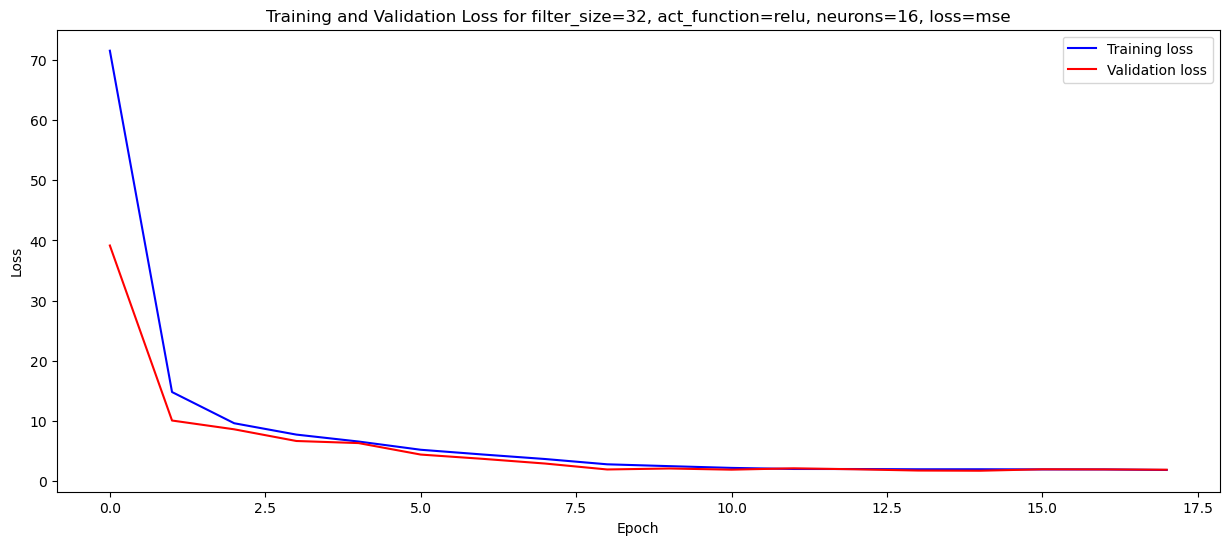


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 17: early stopping


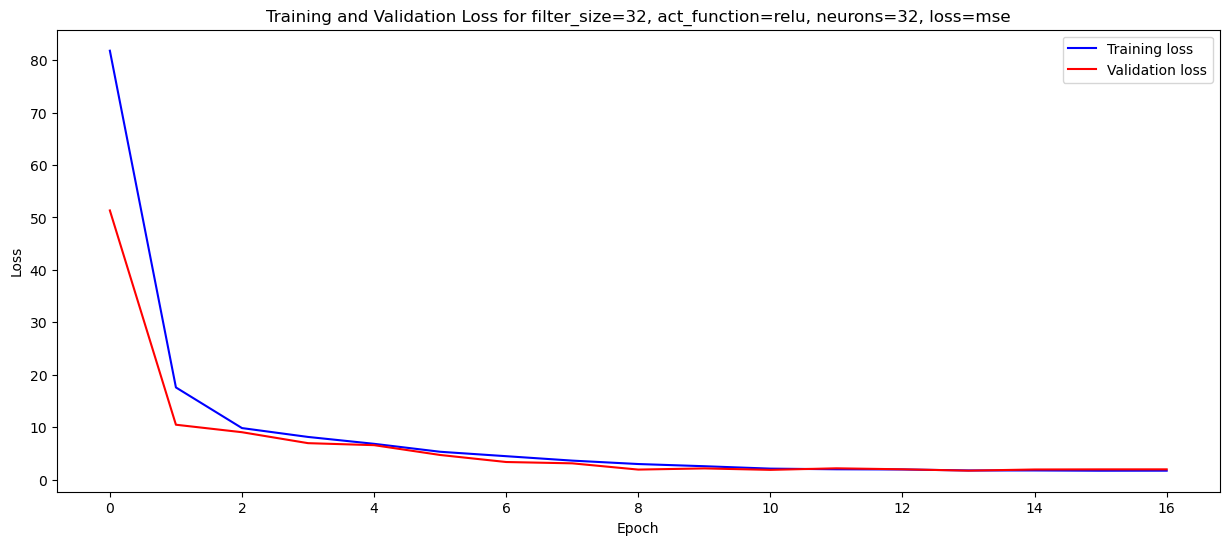


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 8.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping


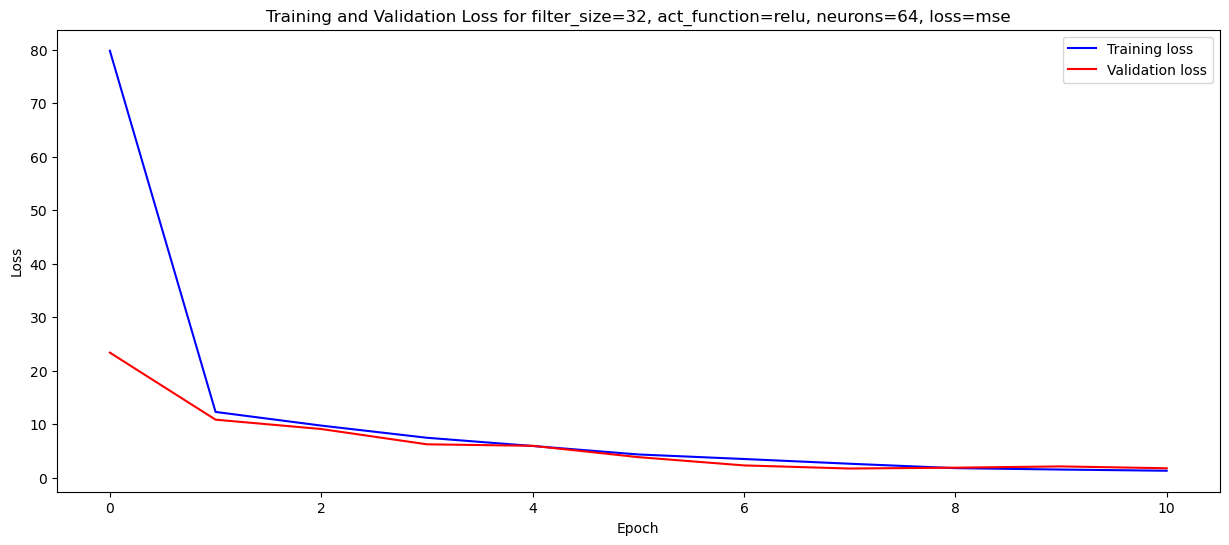


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17: early stopping


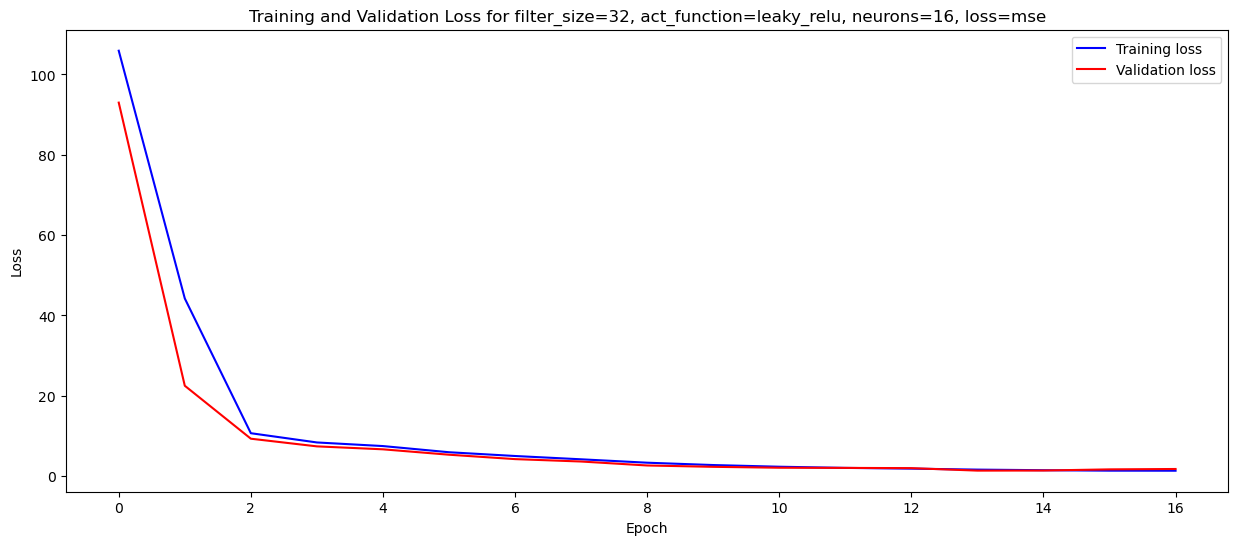


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping


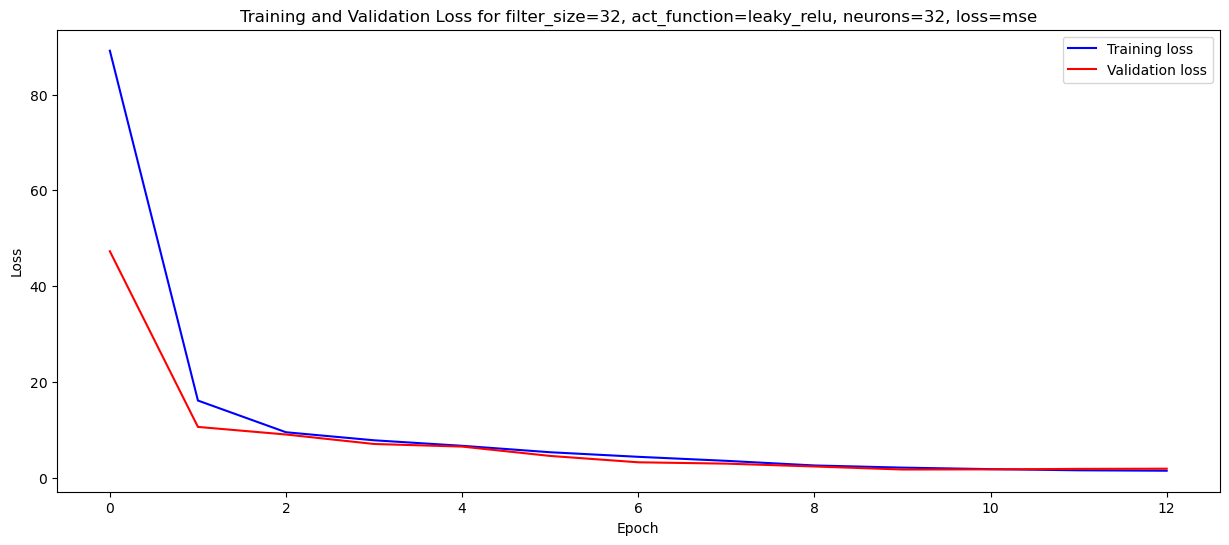


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 14: early stopping


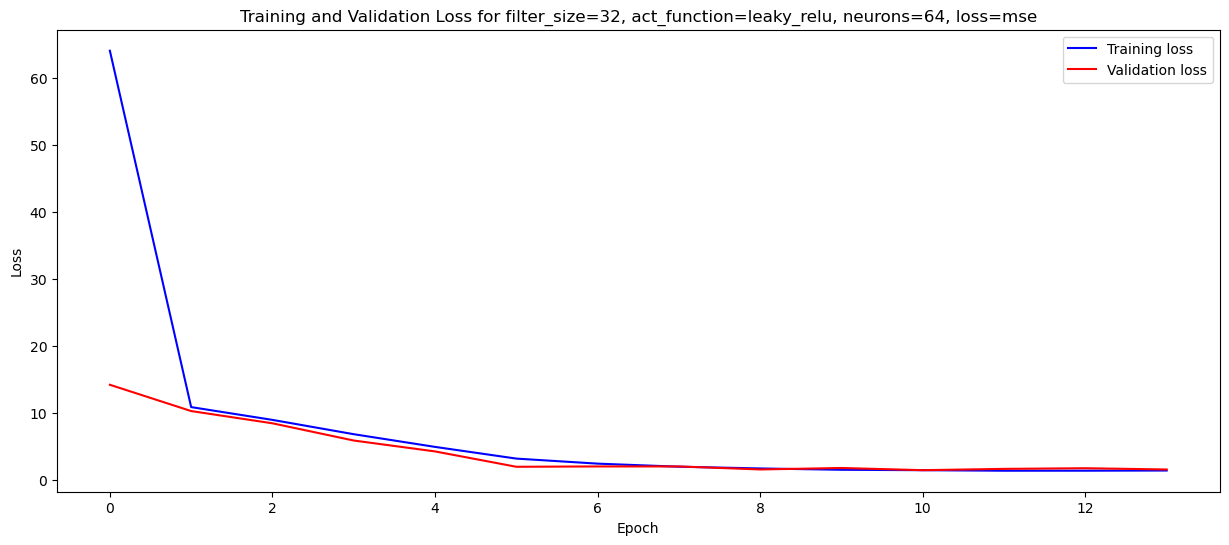


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping


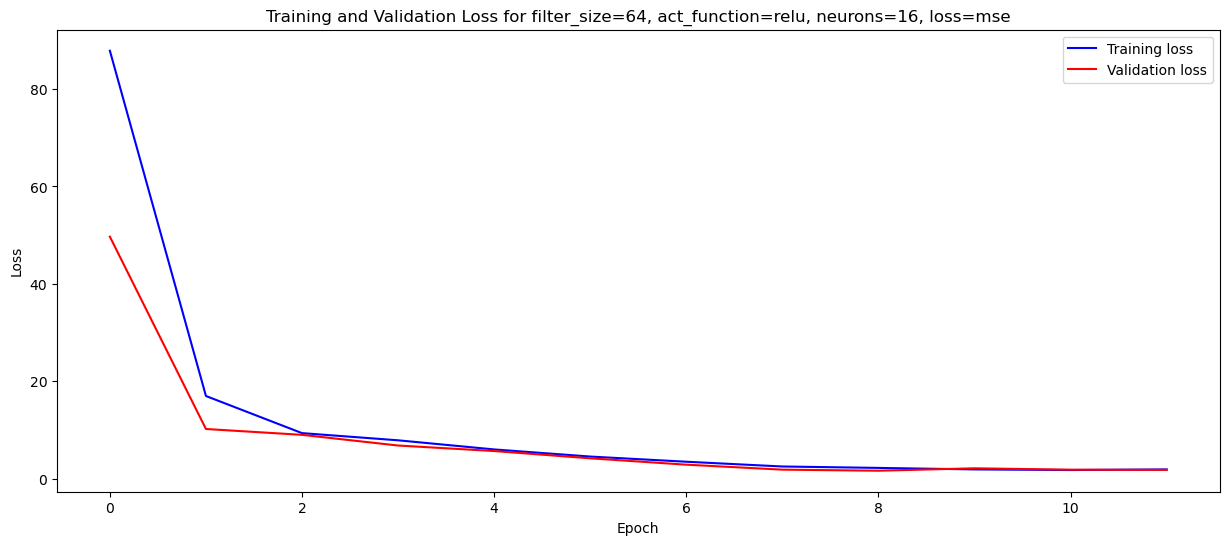


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 15: early stopping


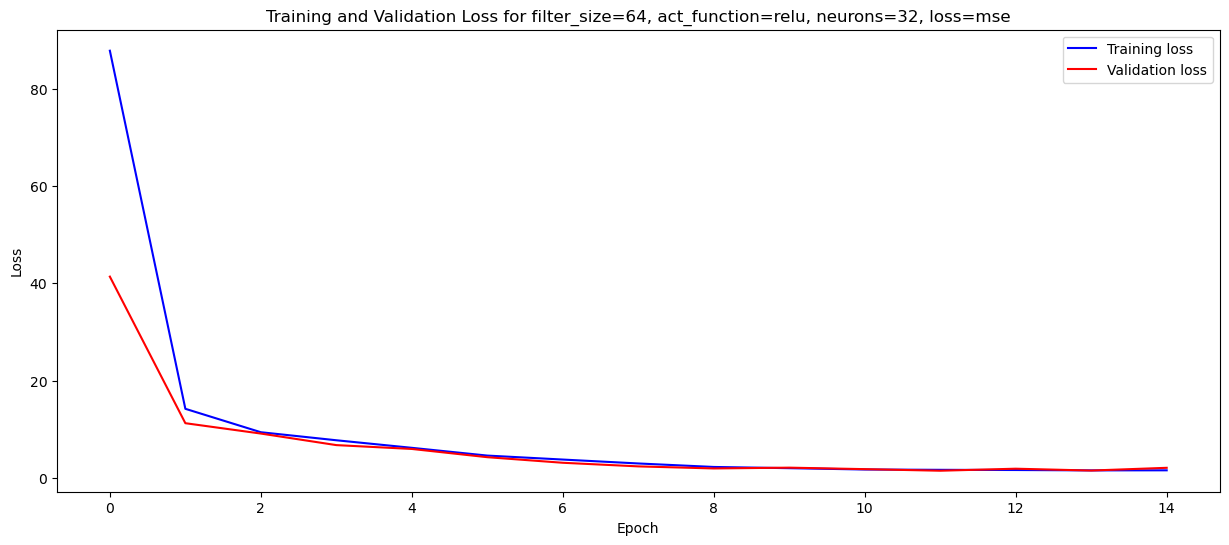


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 6.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 9: early stopping


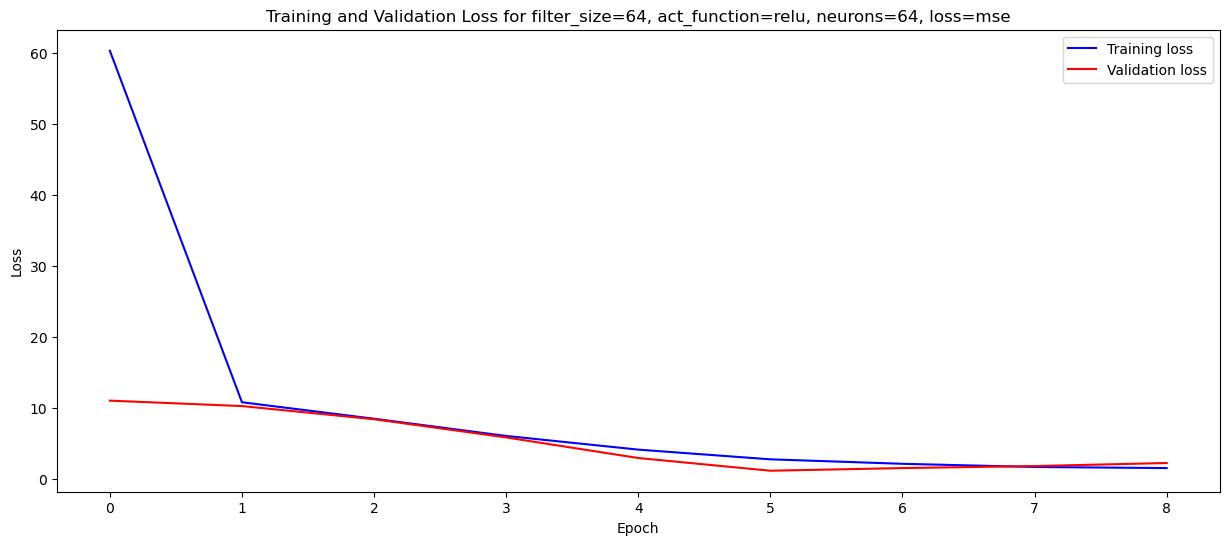


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 12: early stopping


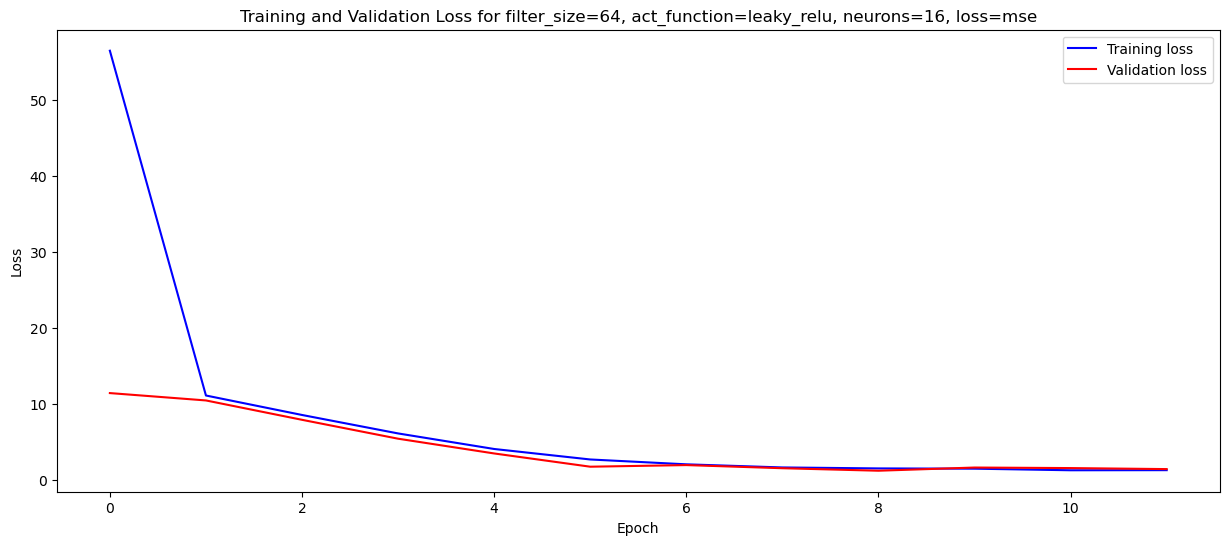


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 7.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 10: early stopping


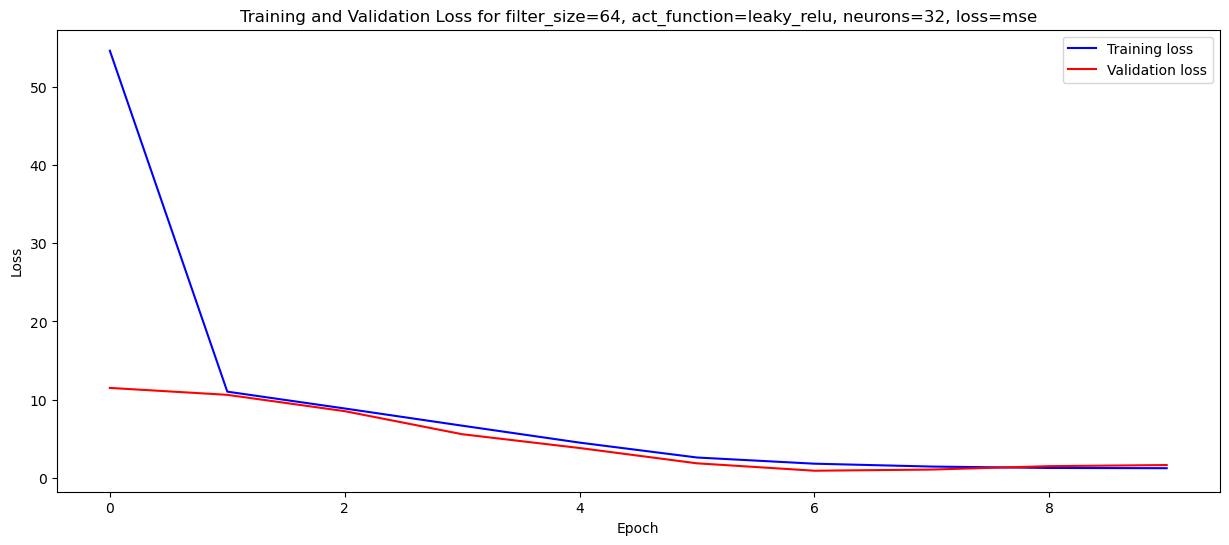


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 12: early stopping


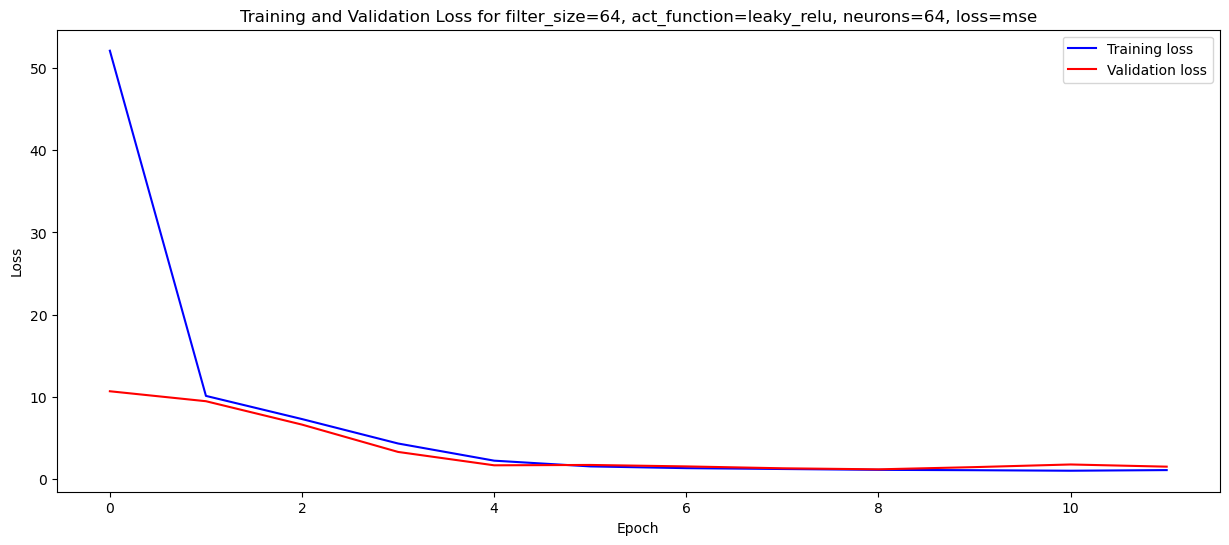


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 12: early stopping


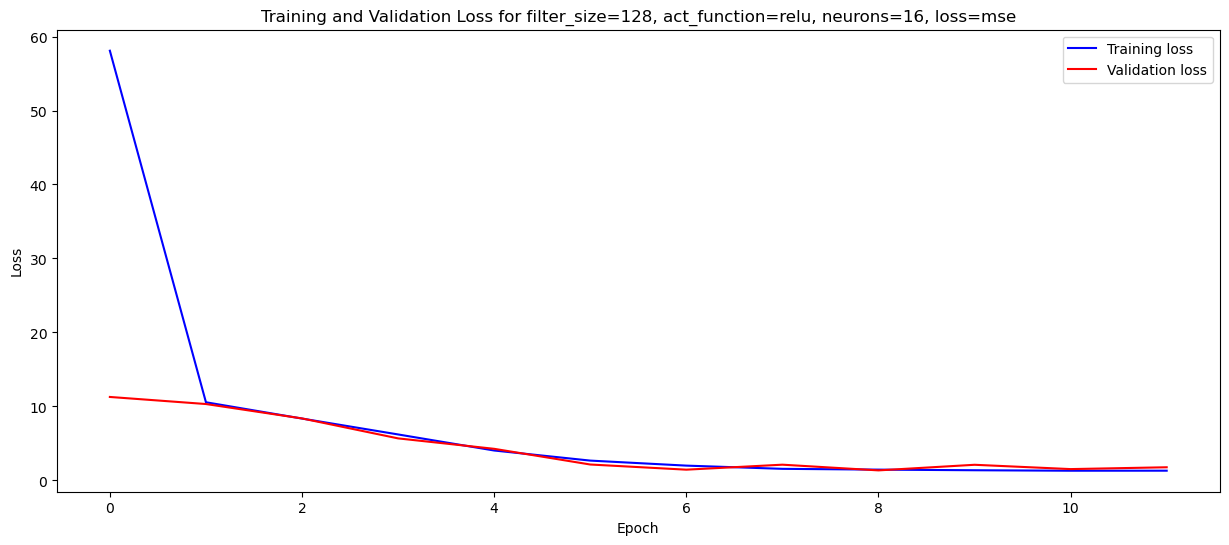


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping


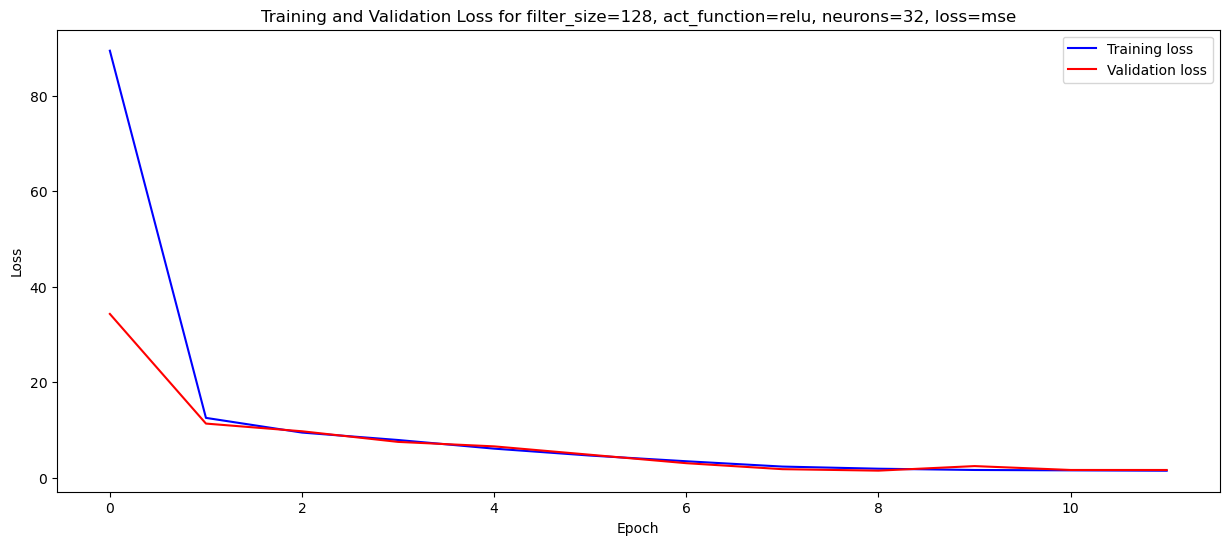


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 7.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 10: early stopping


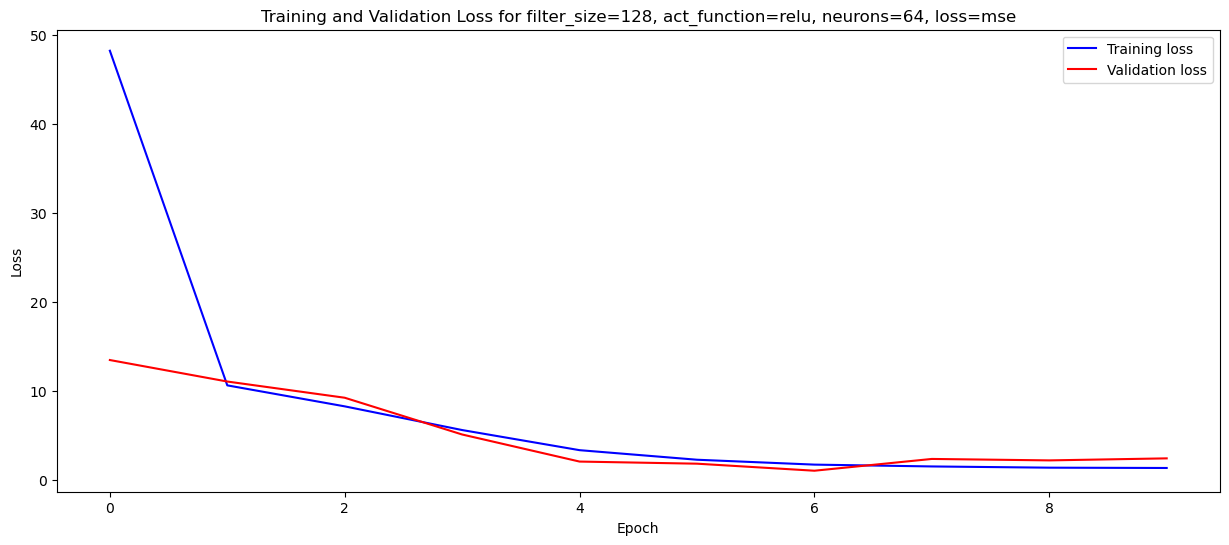


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 6.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 9: early stopping


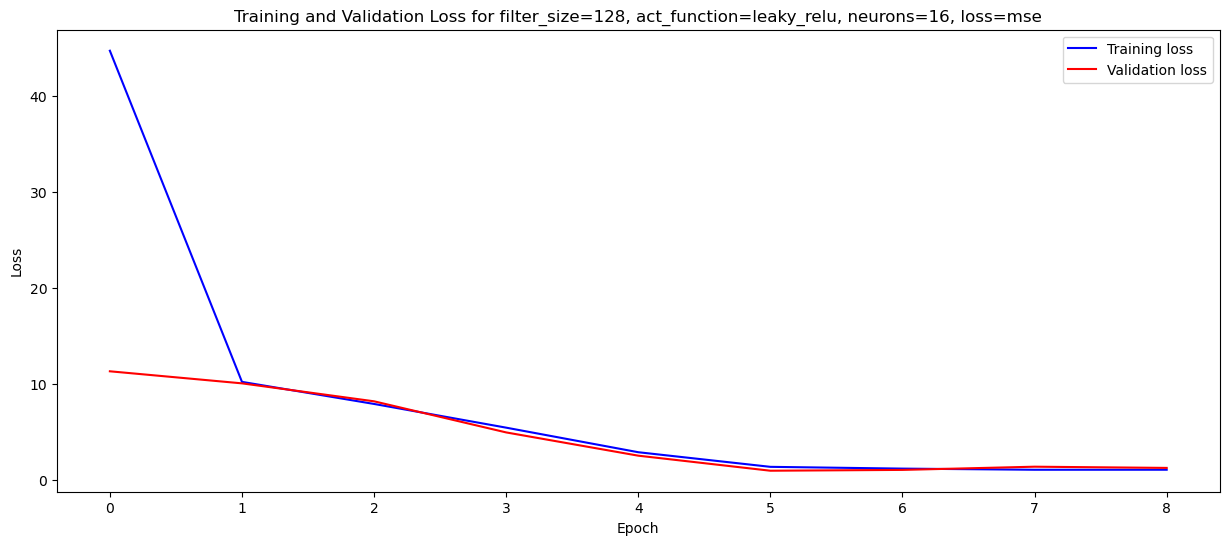


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 12: early stopping


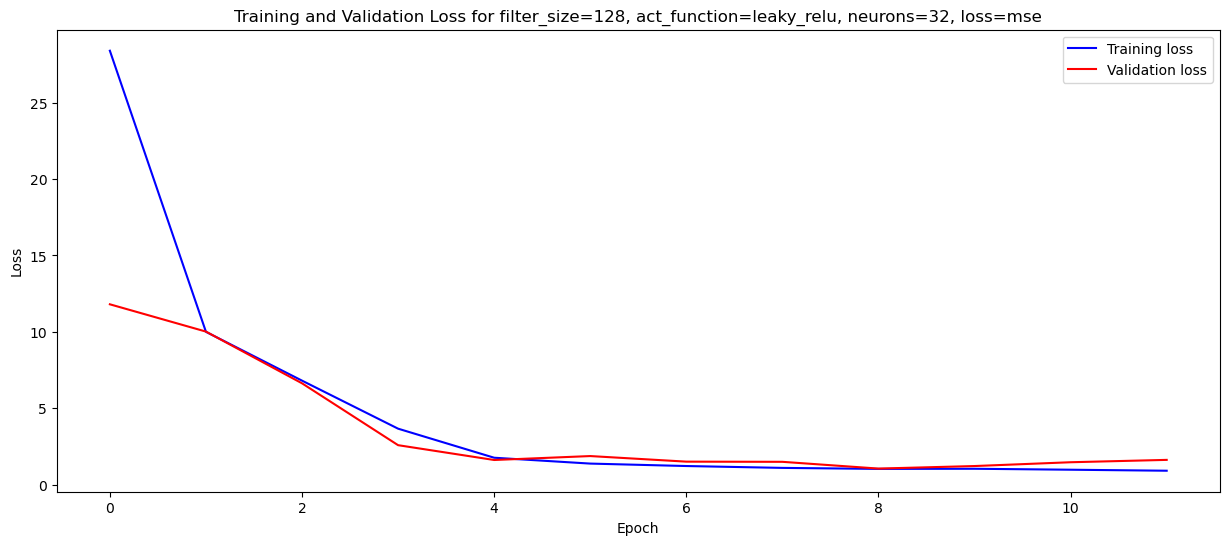


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 7.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 10: early stopping


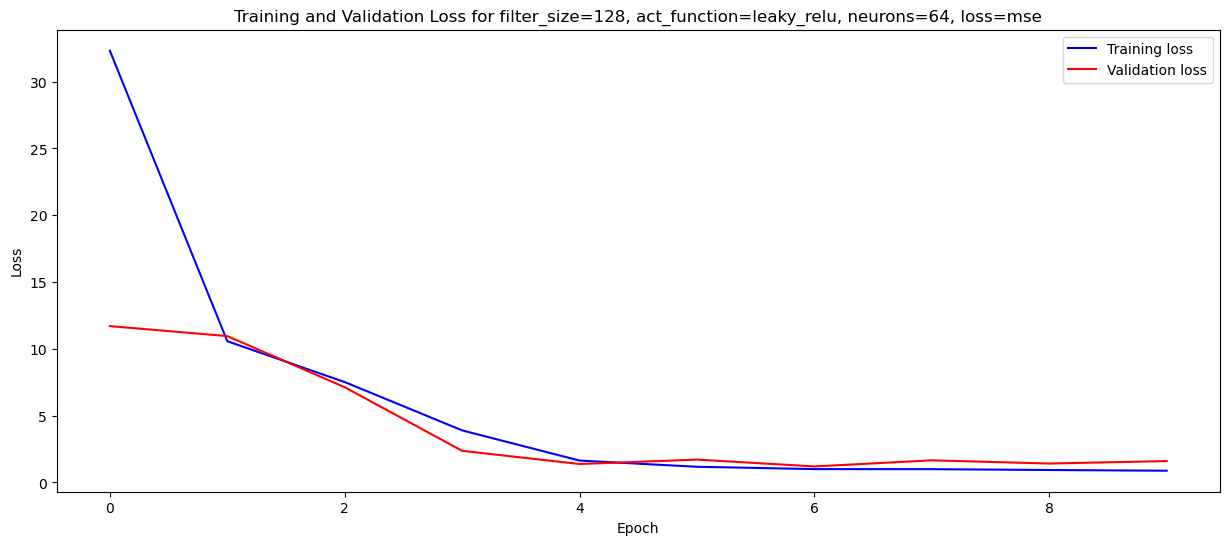

In [18]:
for filter_size in [32, 64, 128]:
    for act_function in ['relu', 'leaky_relu']:
        for neurons in [16, 32, 64]:
            model, log = create_model(filter_size, act_function, neurons, 0.2, 'mse')


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 17: early stopping


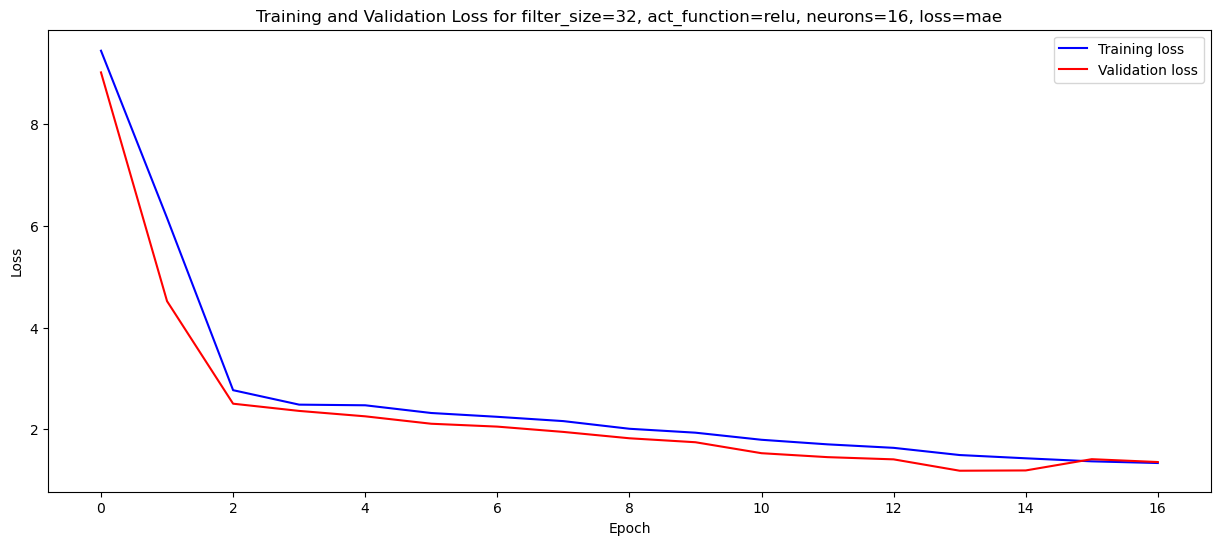


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 17: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 16.

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 19: early stopping


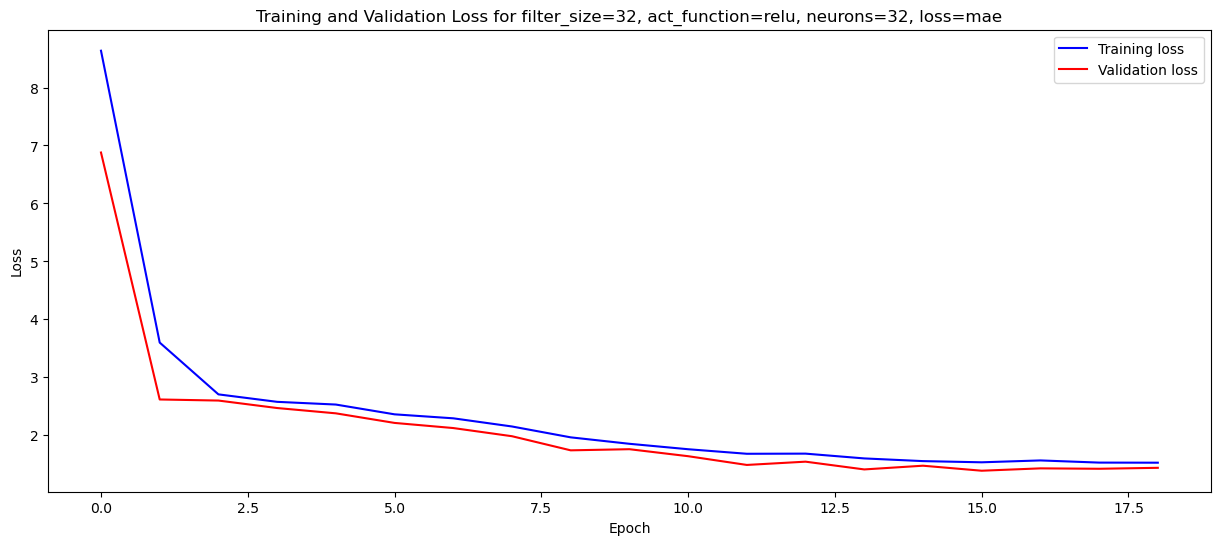


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping


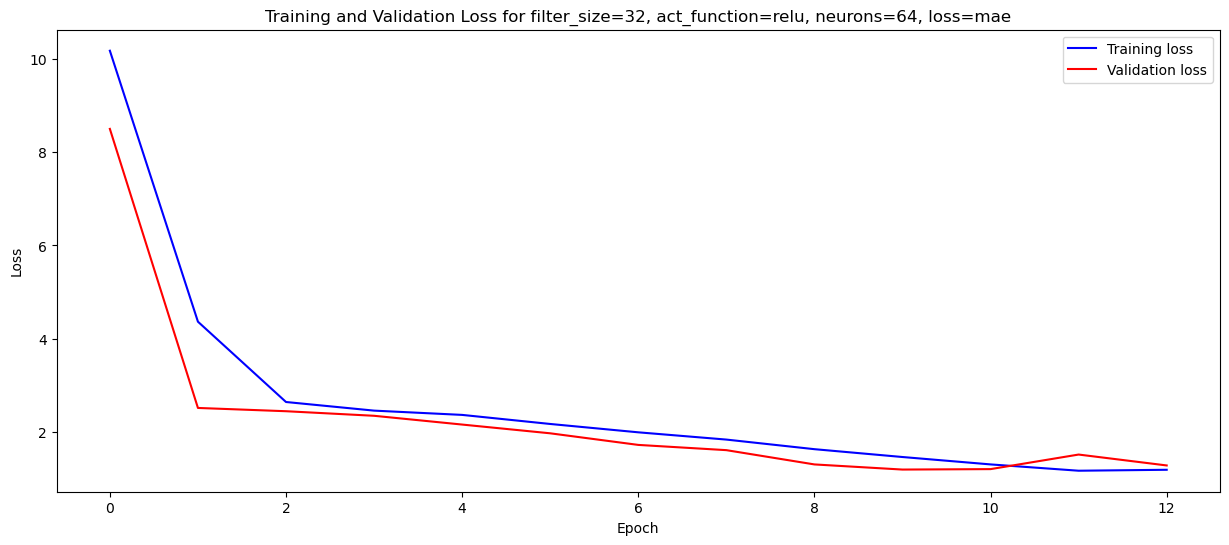


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping


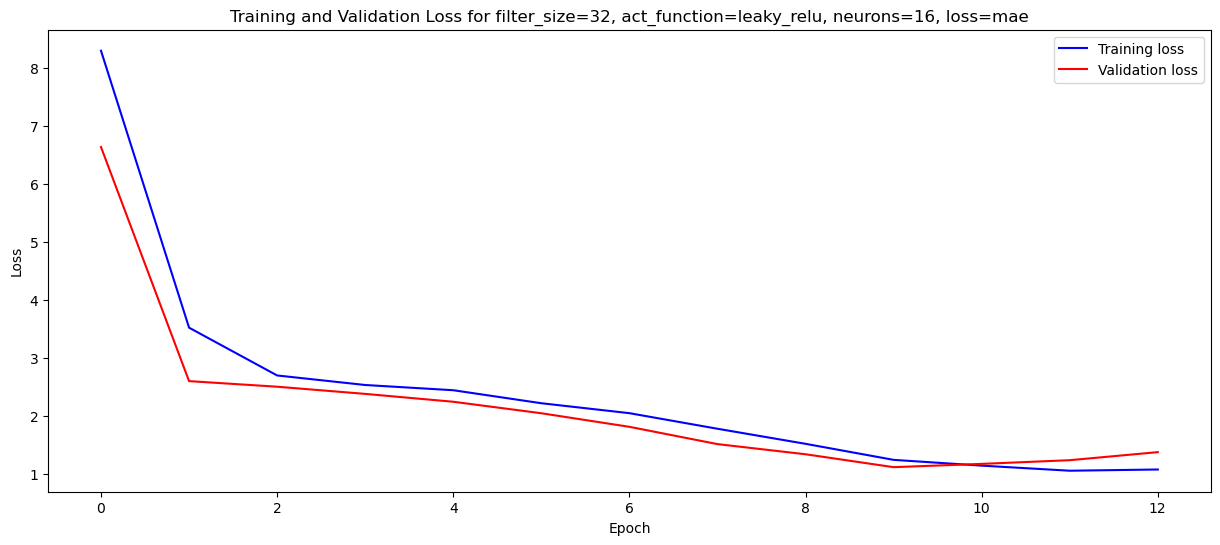


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 13: early stopping


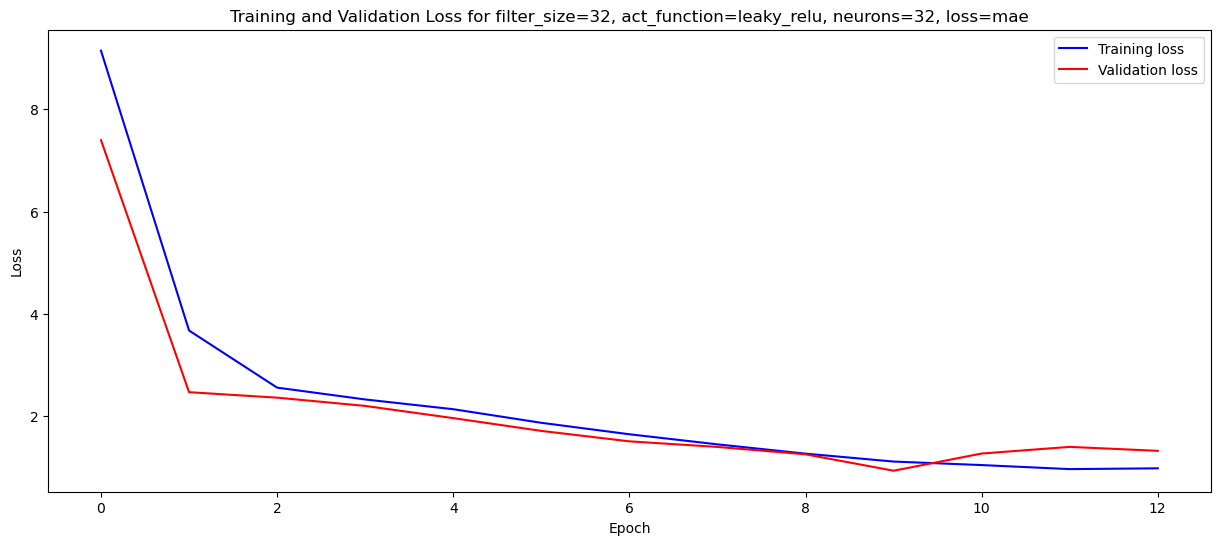


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping


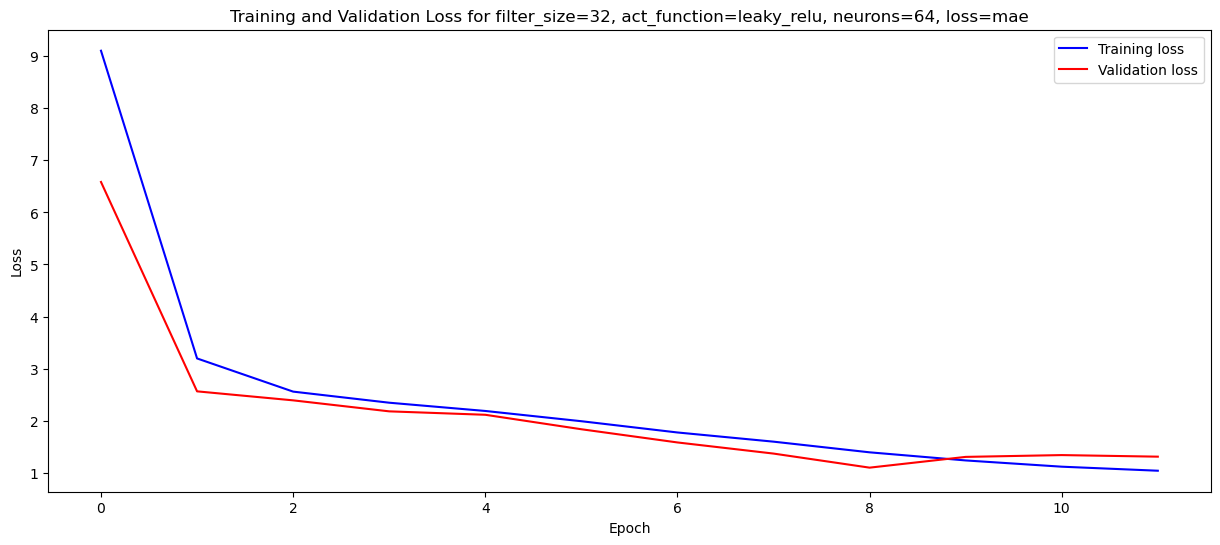


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 13.

Epoch 16: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 16: early stopping


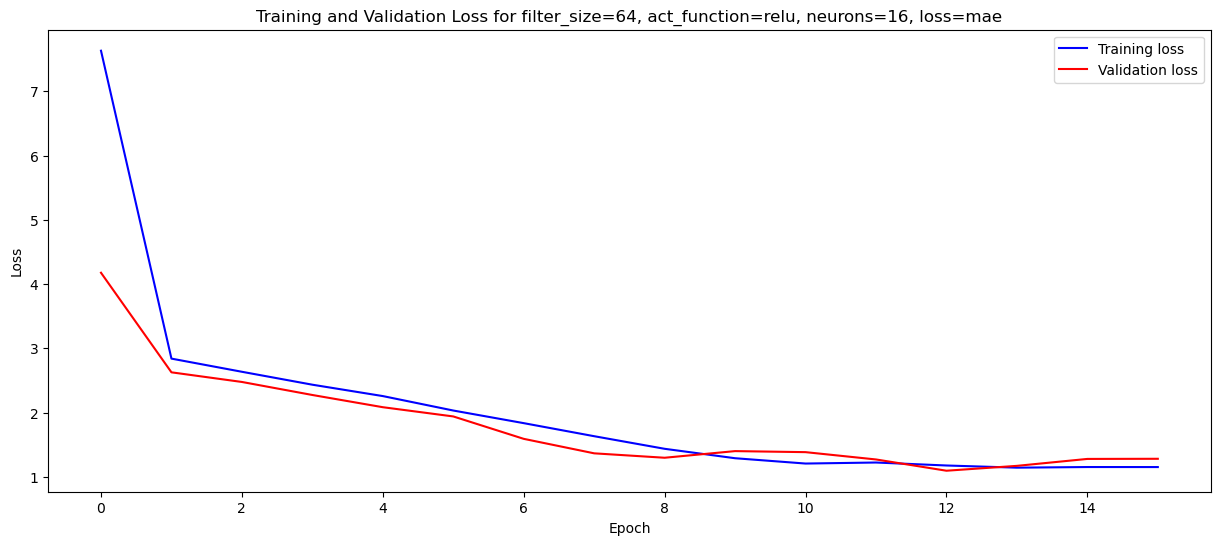


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 13: early stopping


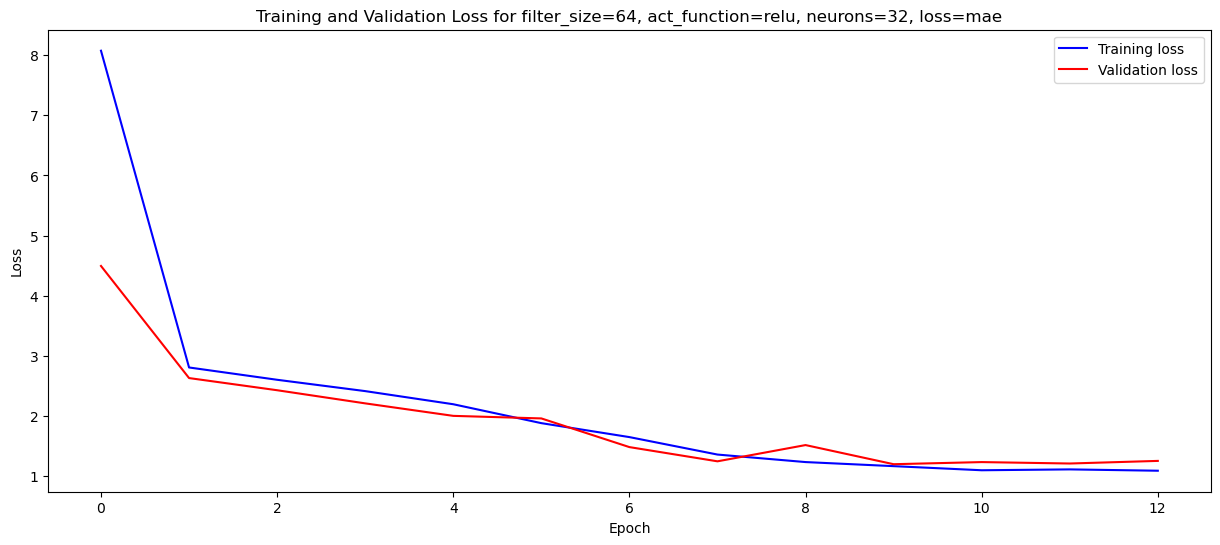


Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 14.

Epoch 17: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 17: early stopping


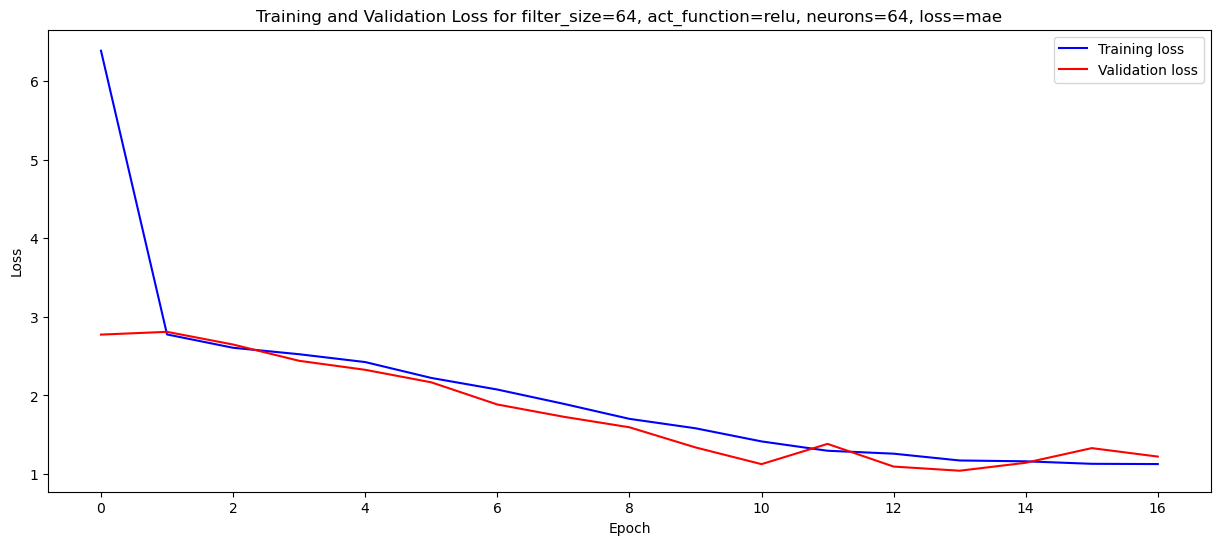


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from the end of the best epoch: 12.

Epoch 15: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 15: early stopping


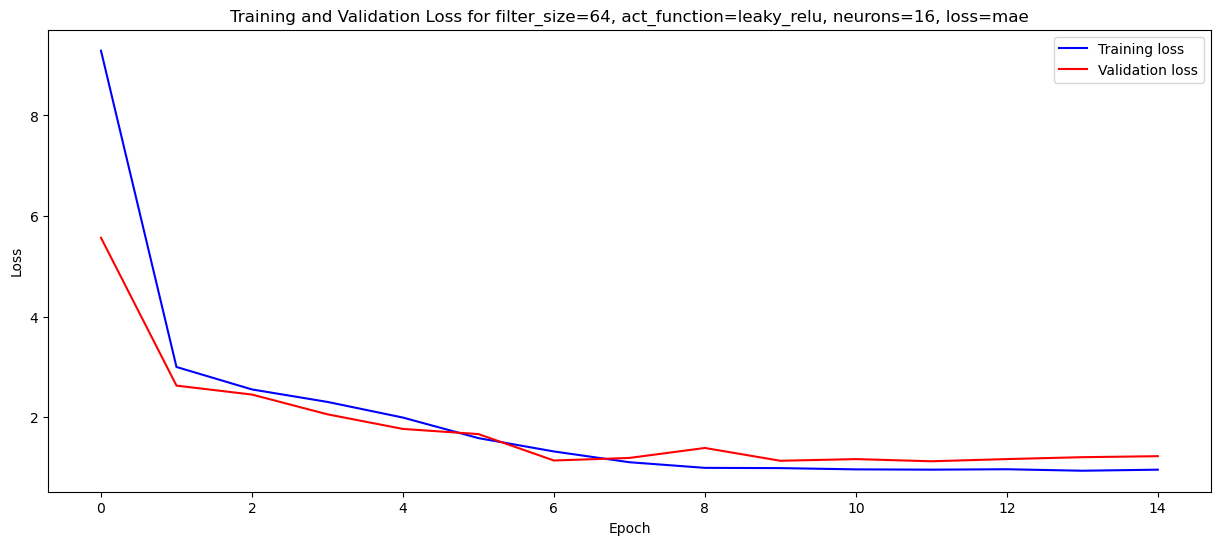


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 8.

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 11: early stopping


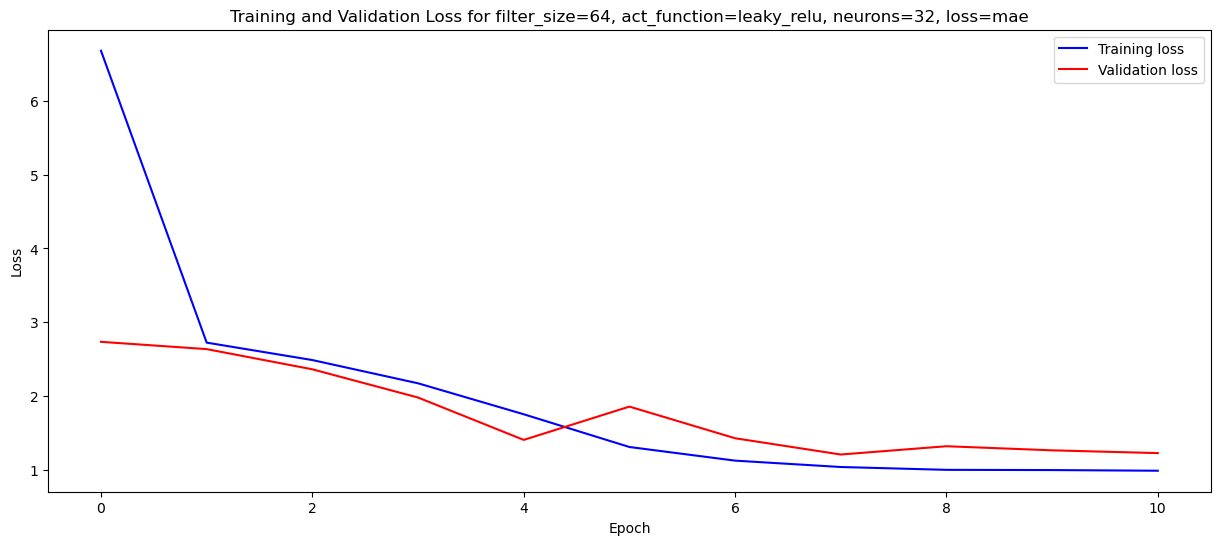


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 8.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping


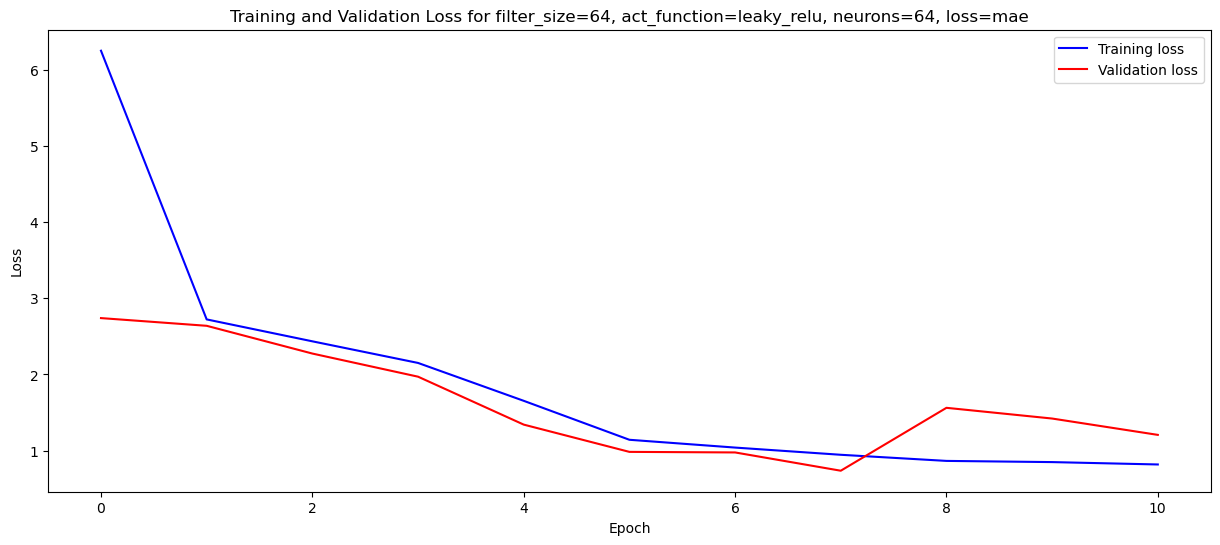


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 9.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 12: early stopping


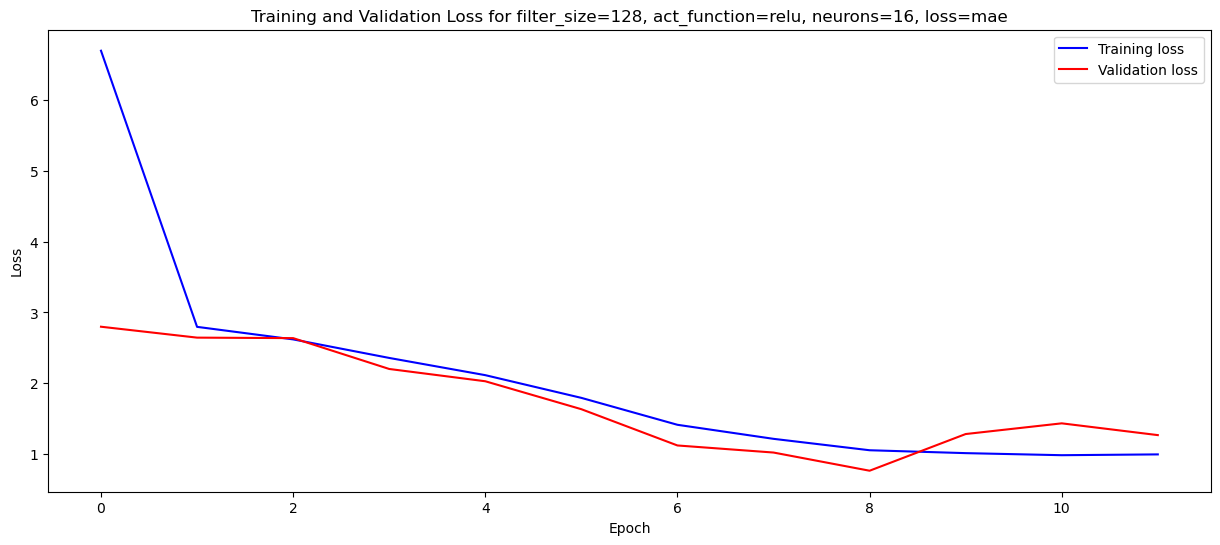


Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 13: early stopping


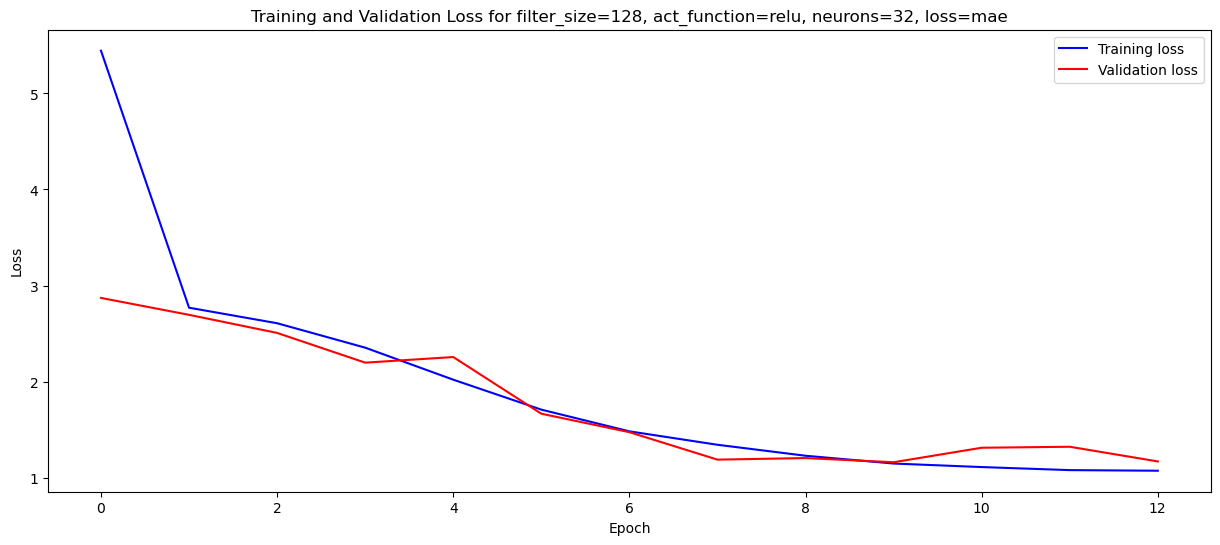


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 6.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 9: early stopping


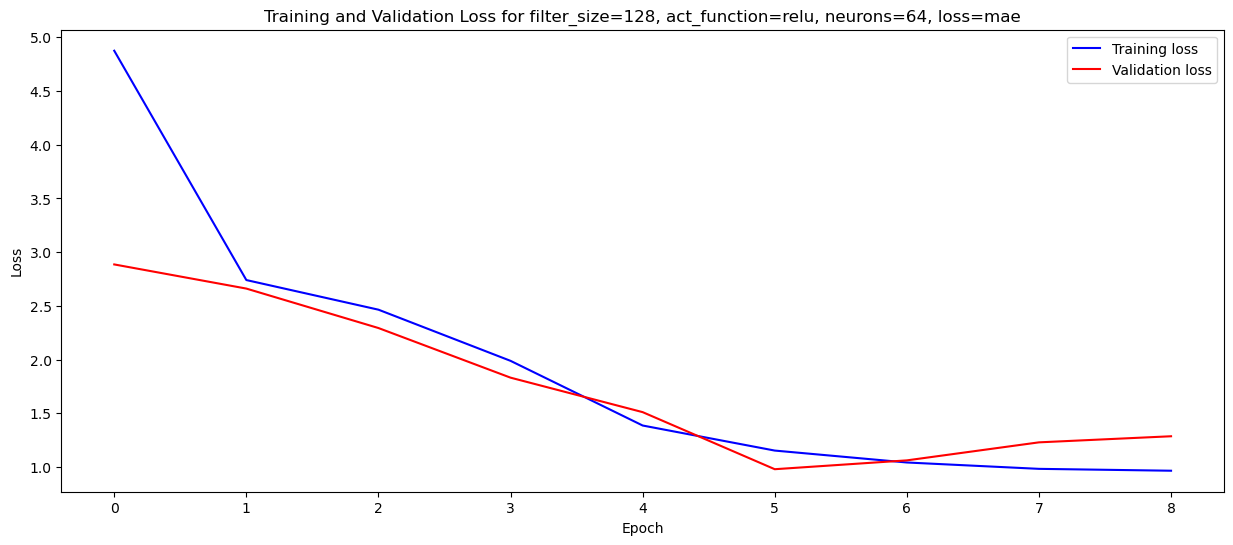


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 5.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 8: early stopping


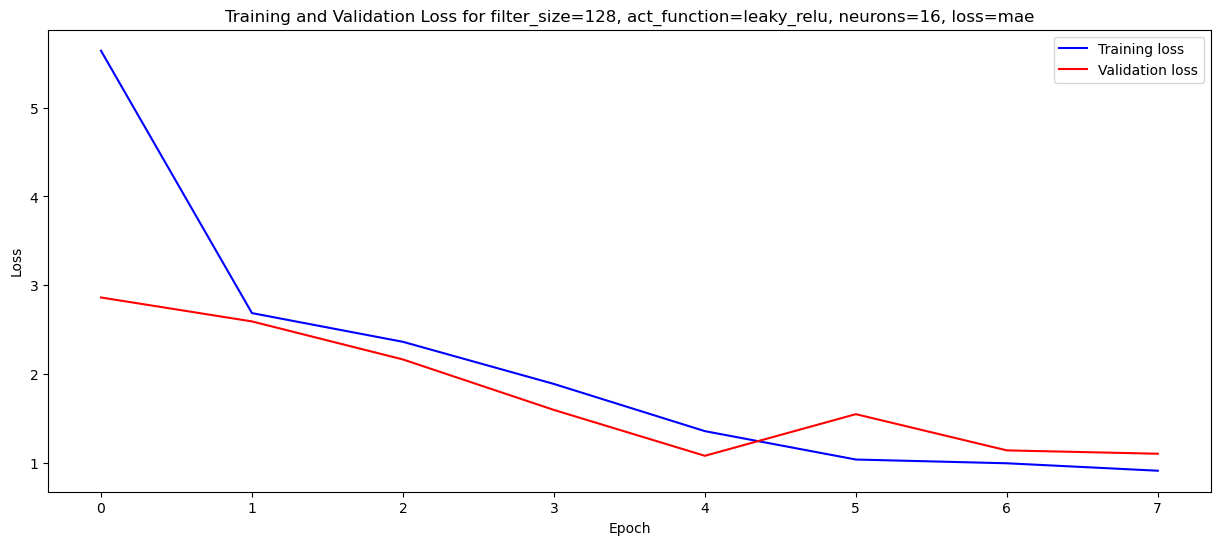


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 8.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 11: early stopping


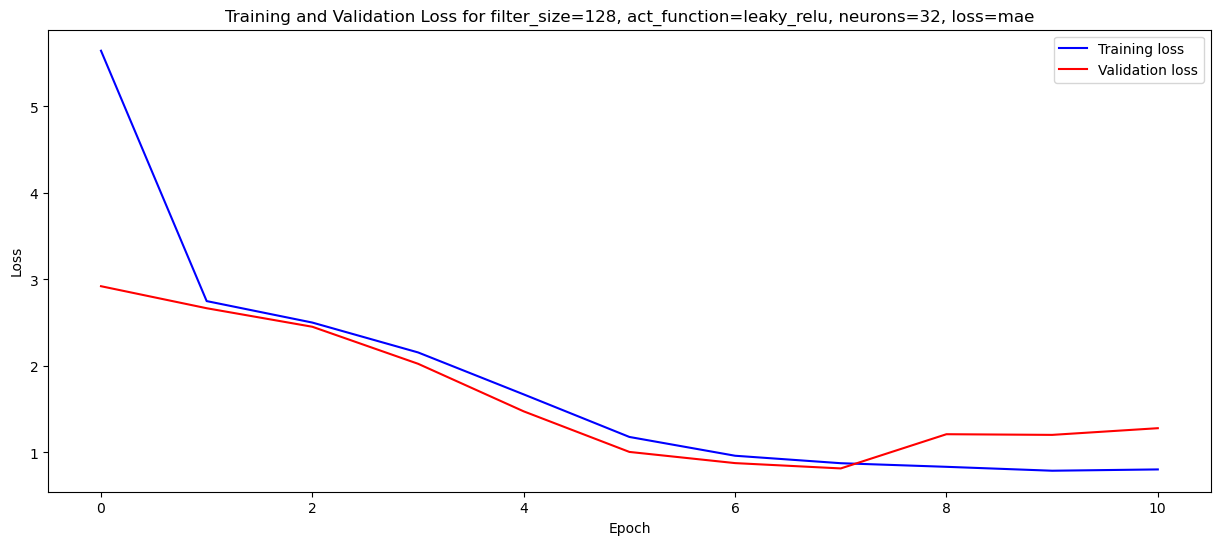


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 7.

Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 10: early stopping


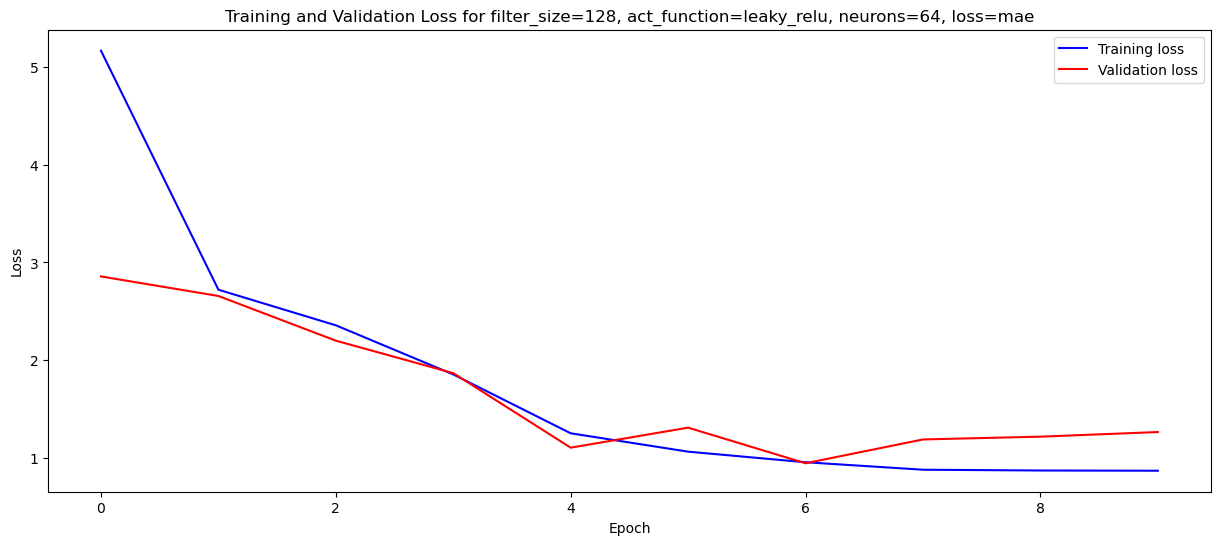

In [19]:
for filter_size in [32, 64, 128]:
    for act_function in ['relu', 'leaky_relu']:
        for neurons in [16, 32, 64]:
            model, log = create_model(filter_size, act_function, neurons, 0.2, 'mae')

## Predicting on H1 2023

In [58]:
# Reading test data for Muddy Creek

df_climate_muddy_creek_test = pd.read_parquet('data/climate/df_climate_muddy_creek_test.parquet')

df_gwl_muddy_creek_test = pd.read_parquet('data/gwl/df_gwl_muddy_creek_test.parquet')

df_climate_muddy_creek_test = df_climate_muddy_creek_test.dropna(axis=0)

df_climate_muddy_creek_test['day_date'] = df_climate_muddy_creek_test['date'].dt.date

df_gwl_muddy_creek_test['day_date'] = df_gwl_muddy_creek_test['datetime'].dt.date

# Find the minimum and maximum values of the date column in df_climate_muddy_creek
muddy_creek_min_date = df_climate_muddy_creek_test['day_date'].min()
muddy_creek_max_date = df_climate_muddy_creek_test['day_date'].max()

muddy_creek_gwl_min_date = df_gwl_muddy_creek_test['day_date'].min()
muddy_creek_gwl_max_date = df_gwl_muddy_creek_test['day_date'].max()


# Print the results
print("df_climate_muddy_creek_test - Min Date:", muddy_creek_min_date)
print("df_climate_muddy_creek_test - Max Date:", muddy_creek_max_date)
print("df_gwl_muddy_creek_test - Min Date:", muddy_creek_gwl_min_date)
print("df_gwl_muddy_creek_test - Max Date:", muddy_creek_gwl_max_date)


df_climate_muddy_creek_test - Min Date: 2023-01-01
df_climate_muddy_creek_test - Max Date: 2023-12-13
df_gwl_muddy_creek_test - Min Date: 2023-01-01
df_gwl_muddy_creek_test - Max Date: 2023-11-30


In [59]:
df_muddy_creek_data_test = df_climate_muddy_creek_test.merge(df_gwl_muddy_creek_test, on='day_date')

df_muddy_creek_data_test = df_muddy_creek_data_test[df_muddy_creek_data_test['day_date'] < pd.to_datetime('2023-06-01')]

day_date = df_muddy_creek_data_test['day_date'].values

x = df_muddy_creek_data_test[['precpinch', 'avgtempf']].values
y = df_muddy_creek_data_test['gwl'].values

x_transformed = sc_climate.transform(x)


/var/folders/zx/w0khk41x0xl08sdt7j90tmr80000gn/T/ipykernel_18115/3771754044.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_muddy_creek_data_test = df_muddy_creek_data_test[df_muddy_creek_data_test['day_date'] < pd.to_datetime('2023-06-01')]



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 11.

Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 14: early stopping


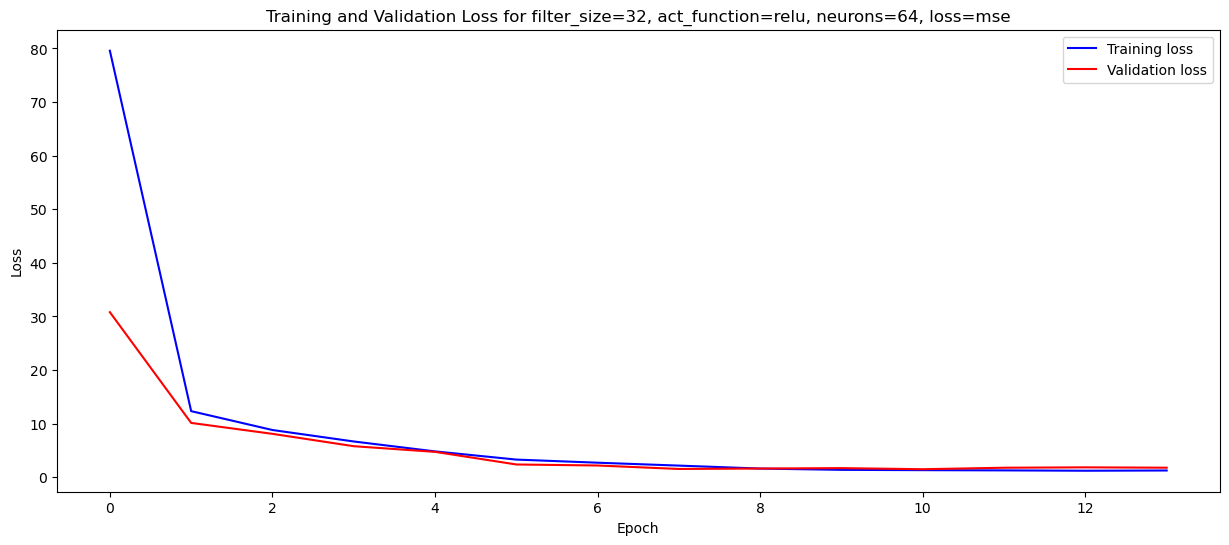

In [60]:
final_model, log = create_model(32, 'relu', 64, 0.2, 'mse')

# 64, 16, 0.2, 'mae'
# 128, 16, 0.2, 'mae'


In [61]:
y_pred = final_model.predict(x_transformed)

5/5 [==============================] - 0s 685us/step


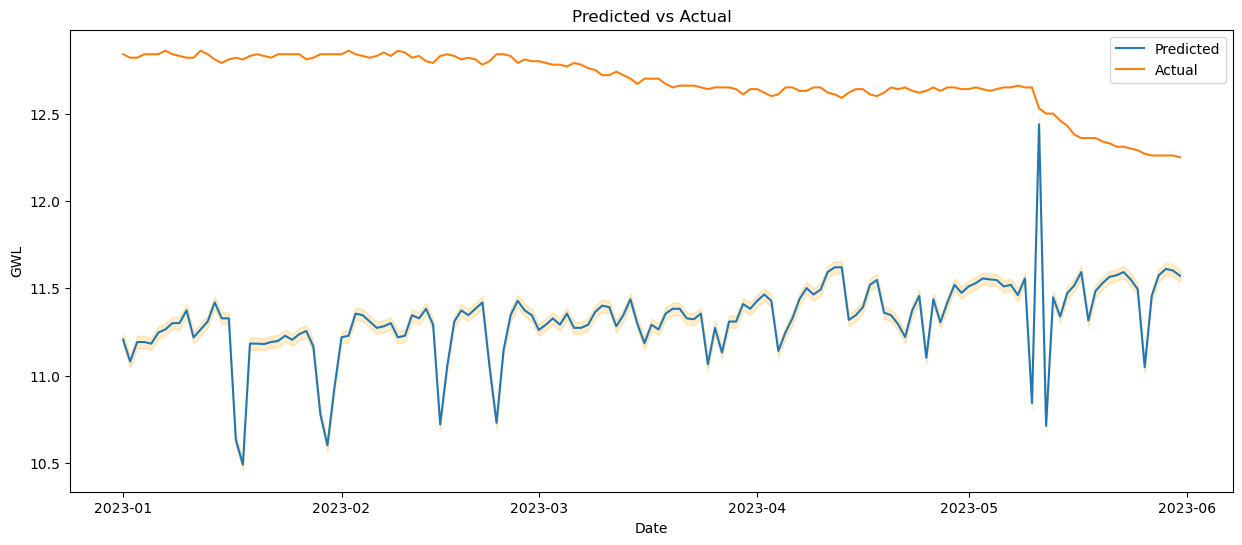

Mean Absolute Error: 1.3620353554731963
Root Mean Squared Error: 1.401426121844789
Mean Absolute Percentage Error: 0.10712682988142126


In [62]:
# Plot y_pred vs y
y_pred = [y[0] for y in y_pred]

confidence_interval = 1.96 * np.std(y_pred)/np.sqrt(len(y_pred))

plt.figure(figsize=(15, 6))
plt.plot(day_date, y_pred, label='Predicted')
plt.plot(day_date, y, label='Actual')
plt.fill_between(day_date, y_pred-confidence_interval, y_pred+confidence_interval, alpha=0.2, color='orange')
plt.title('Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()

mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
mape = mean_absolute_percentage_error(y, y_pred)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)

### Predicting on H2 2023

6/6 [==============================] - 0s 586us/step


/var/folders/zx/w0khk41x0xl08sdt7j90tmr80000gn/T/ipykernel_18115/283997302.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_muddy_creek_data_test = df_muddy_creek_data_test[df_muddy_creek_data_test['day_date'] >= pd.to_datetime('2023-06-01')]


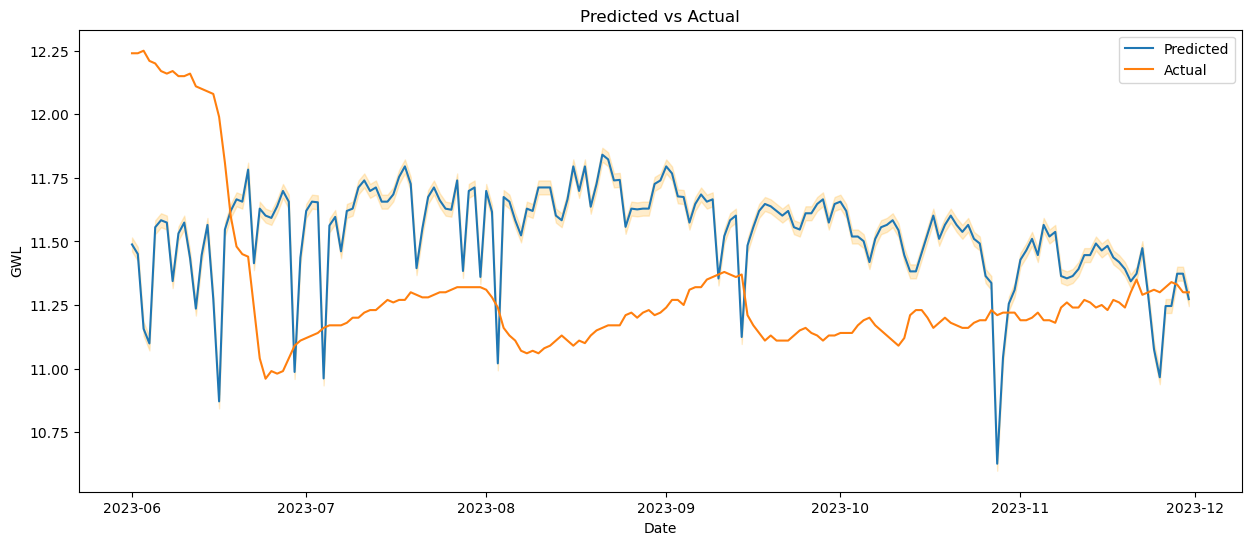

Mean Absolute Error: 0.39763607650506694
Root Mean Squared Error: 0.44841963827756043
Mean Absolute Percentage Error: 0.03508243871415155


In [63]:
df_muddy_creek_data_test = df_climate_muddy_creek_test.merge(df_gwl_muddy_creek_test, on='day_date')

df_muddy_creek_data_test = df_muddy_creek_data_test[df_muddy_creek_data_test['day_date'] >= pd.to_datetime('2023-06-01')]

day_date = df_muddy_creek_data_test['day_date'].values

x = df_muddy_creek_data_test[['precpinch', 'avgtempf']].values
y = df_muddy_creek_data_test['gwl'].values

x_transformed = sc_climate.transform(x)

y_pred = final_model.predict(x_transformed)

y_pred = [y[0] for y in y_pred]

confidence_interval = 1.96 * np.std(y_pred)/np.sqrt(len(y_pred))

plt.figure(figsize=(15, 6))
plt.plot(day_date, y_pred, label='Predicted')
plt.plot(day_date, y, label='Actual')
plt.fill_between(day_date, y_pred-confidence_interval, y_pred+confidence_interval, alpha=0.2, color='orange')
plt.title('Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()

mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
mape = mean_absolute_percentage_error(y, y_pred)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)